In [1]:
import sys
import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Add the project root directory (not src) to sys.path
sys.path.append(os.path.abspath("../src/data/"))

# Now import the DataLoader class
from data_loading import DataLoader

raw = '../data/RAW/'
clean = '../data/CLEAN'

In [2]:
data_loader = DataLoader(raw,clean)
data_loader.show_data_folder()

raw data 

CMU_Movies_Dataset
GVD_Dataset
Human_labelling_violentMovie.xlsx
Kaggle_Movies_Dataset

clean data 

word_count.csv
empath_features_matrix.tsv
violent_word_list
human_label_flourish.xlsx
violent_movie_study
GVD_clean.csv
sentiment.csv
movie_violence_metric.csv
sentiment_test.csv
empath_features_matrix_norm.tsv
Human_labelling_violentMovie.xlsx
classification_result
Movie_Data_clean.tsv
word_count_test.csv


In [3]:
MovieData = data_loader.clean_movie_data()
Violent_metrics = pd.read_csv("../data/CLEAN/classification_result/LLM_result_binary.csv")

In [4]:
MovieData.head()

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
21926710,White on Rice,2009-05-31,NaN,NaN,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...


In [5]:
Violent_metrics.set_index("Wikipedia movie ID",inplace=True)
Violent_metrics.head()

,Result,Prediction
Wikipedia movie ID,,
975900,Violent,1.0
6631279,Non-violent,-1.0
77856,Non-violent,-1.0
21926710,Non-violent,-1.0
156558,Violent,1.0


In [6]:
MovieData_Violent = MovieData[Violent_metrics["Prediction"] == 1.0]
MovieData_Peaceful = MovieData[Violent_metrics["Prediction"] == -1.0]
MovieData_Violent.head()

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
4951456,Kinjite: Forbidden Subjects,1989-02-03,3416846.0,English Language,United States of America,"Crime Fiction, Action/Adventure, Action, Thriller",a japanese businessman sees a woman being grop...
1369204,Juarez,1939-06-10,NaN,"English Language, Spanish Language",United States of America,"Costume drama, Biographical film, Historical f...",the film focuses on the conflict between maxim...
2647998,The Human Tornado,1976-10-02,NaN,English Language,United States of America,"Action/Adventure, Action Comedy, Cult, Blaxplo...","after coming off a successful comedy tour, dol..."


## Extract genres

In [7]:
print(MovieData_Peaceful[MovieData_Peaceful["Genres"].isna()].shape)
print(MovieData_Violent[MovieData_Violent["Genres"].isna()].shape)

(0, 7)
(0, 7)


In [8]:
def genres_extraction (y):
 return [element for element in y.split(", ")]

In [9]:
genresTotal = pd.DataFrame(pd.DataFrame(MovieData["Genres"].apply(genres_extraction).explode()).value_counts())
genresViolent = pd.DataFrame(pd.DataFrame(MovieData_Violent["Genres"].apply(genres_extraction).explode()).value_counts())
genresPeaceful = pd.DataFrame(pd.DataFrame(MovieData_Peaceful["Genres"].apply(genres_extraction).explode()).value_counts())

In [10]:
genresViolent["Total"] = genresViolent.index.map(genresTotal["count"])
genresPeaceful["Total"] = genresPeaceful.index.map(genresTotal["count"])

In [11]:
genresViolent["Weight"] = genresViolent["count"]/genresViolent["Total"]
genresPeaceful["Weight"] = genresPeaceful["count"]/genresPeaceful["Total"]

In [12]:
genresViolent.to_csv(clean+"/violent_movie_study/"+"violent_genre.csv")
genresPeaceful.to_csv(clean+"/violent_movie_study/"+"peaceful_genre.csv")

## Analysis in time

In [16]:
# Let's take care of the dates to have the (Week - Year) format
MovieData["Year"] = pd.to_datetime(MovieData["Release date"]).dt.year
MovieData["Week"] = pd.to_datetime(MovieData["Release date"]).dt.isocalendar().week

# Let's take care of the dates to have the (Week - Year) format
MovieData_Violent["Year"] = pd.to_datetime(MovieData_Violent["Release date"]).dt.year
MovieData_Violent["Week"] = pd.to_datetime(MovieData_Violent["Release date"]).dt.isocalendar().week
MovieData_Violent.head()

/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_93266/1577211352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MovieData_Violent["Year"] = pd.to_datetime(MovieData_Violent["Release date"]).dt.year
/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_93266/1577211352.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MovieData_Violent["Week"] = pd.to_datetime(MovieData_Violent["Release date"]).dt.isocalendar().week


,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot,Year,Week
Wikipedia movie ID,,,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th...",2001,34
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...,2001,26
4951456,Kinjite: Forbidden Subjects,1989-02-03,3416846.0,English Language,United States of America,"Crime Fiction, Action/Adventure, Action, Thriller",a japanese businessman sees a woman being grop...,1989,5
1369204,Juarez,1939-06-10,NaN,"English Language, Spanish Language",United States of America,"Costume drama, Biographical film, Historical f...",the film focuses on the conflict between maxim...,1939,23
2647998,The Human Tornado,1976-10-02,NaN,English Language,United States of America,"Action/Adventure, Action Comedy, Cult, Blaxplo...","after coming off a successful comedy tour, dol...",1976,40


In [17]:
Movie_date = MovieData["Year"].value_counts().sort_index()
Violent_movie_date = MovieData_Violent["Year"].value_counts().sort_index()

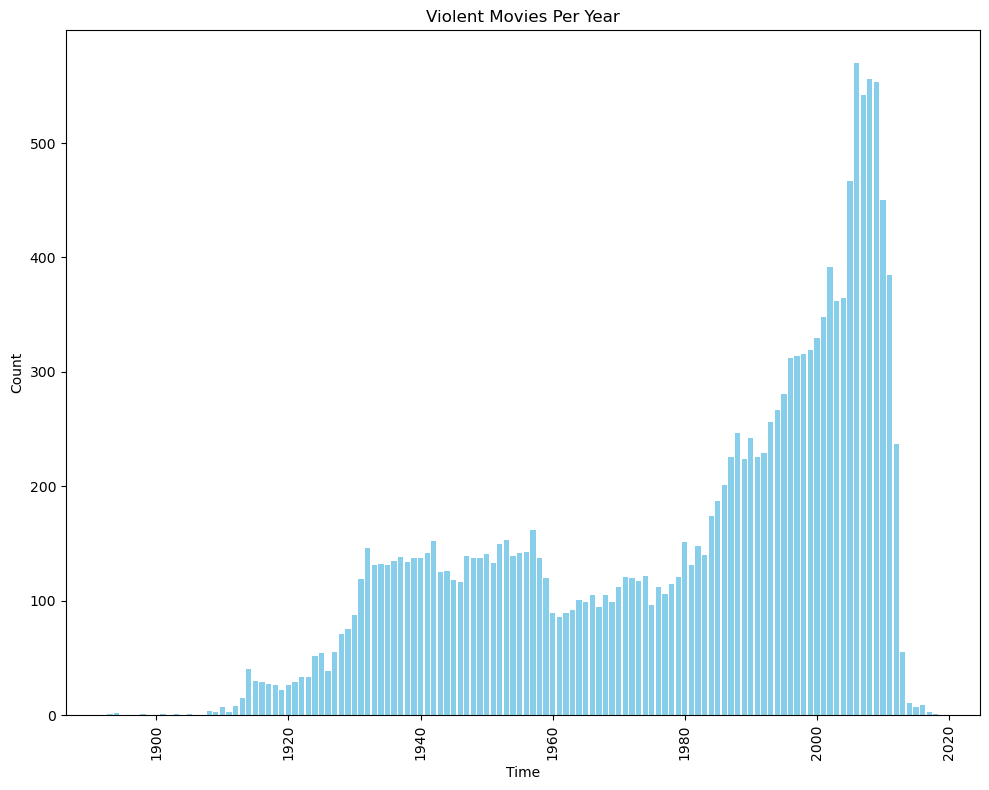

In [18]:
plt.figure(figsize=(10, 8))

plt.bar(
    Movie_date.index,  # X-axis: Date labels (Year-Week)
    Movie_date,     # Y-axis: Count of events
    color='skyblue'
)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Violent Movies Per Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [19]:
Total_count = pd.merge(Movie_date.to_frame(name= "Total"),Violent_movie_date.to_frame(name= "Violent"), left_index=True, right_index=True, how="outer").fillna(0)

In [20]:
Total_count["Ratio"] = Total_count["Violent"]/Total_count["Total"]

In [21]:
Total_count.to_csv(clean+"/violent_movie_study/"+"count_per_year.csv")

In [22]:
Movie_date_week = MovieData.groupby("Year")["Week"].value_counts()
Violent_movie_date_week = MovieData_Violent.groupby("Year")["Week"].value_counts()

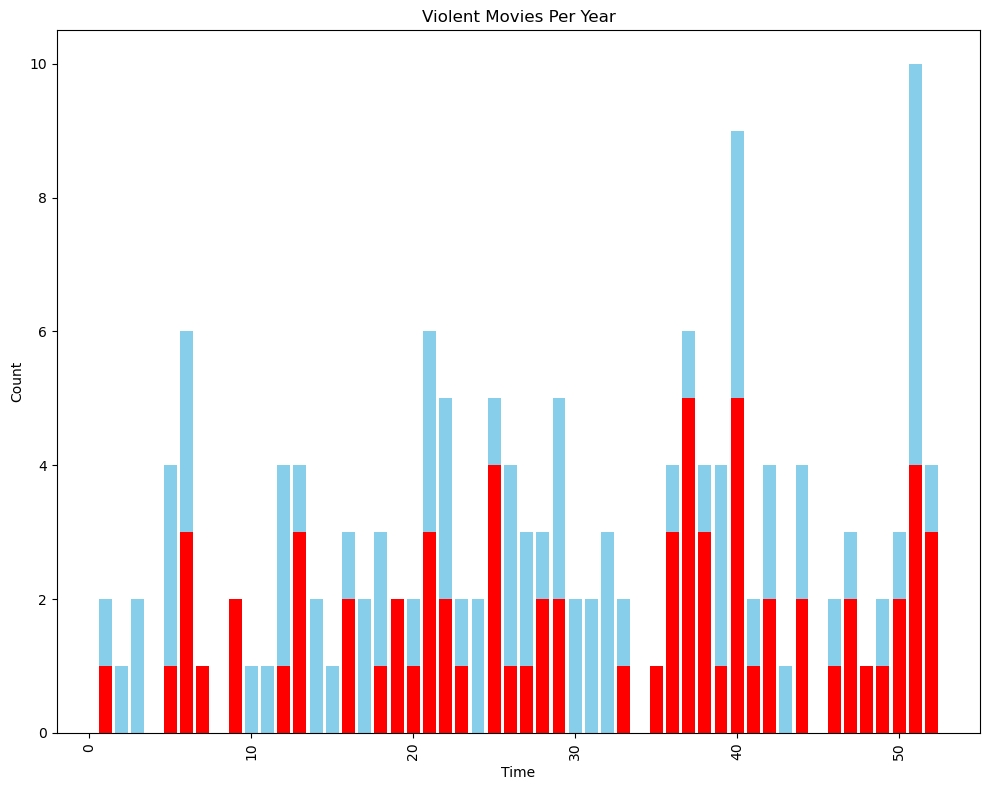

In [23]:
plt.figure(figsize=(10, 8))

plt.bar(
    Movie_date_week.loc[1980].index,  # X-axis: Date labels (Year-Week)
    Movie_date_week.loc[1980],     # Y-axis: Count of events
    color='skyblue'
)

plt.bar(
    Violent_movie_date_week.loc[1980].index,  # X-axis: Date labels (Year-Week)
    Violent_movie_date_week.loc[1980],     # Y-axis: Count of events
    color='red'
)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Violent Movies Per Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [24]:
Total_count_week = pd.merge(pd.DataFrame(Movie_date_week),pd.DataFrame(Violent_movie_date_week), left_index=True, right_index=True, how="outer").fillna(0)

In [25]:
Total_count_week.rename(columns={"count_x":"Total","count_y":"Violent"},inplace=True)

In [26]:
Total_count_week.to_csv(clean+"/violent_movie_study/"+"count_per_week.csv")

In [27]:
Total_count_week.head()

Total  Violent
Year Week                
1893 19        1        0
1894 41        1        0
     46        1        0
1898 20        1        0
1901 8         1        1

In [72]:
Matrix_violence = pd.DataFrame(Violent_movie_date_week).unstack(level=0).fillna(0)
Matrix_total = pd.DataFrame(Movie_date_week).unstack(level=0).fillna(0)
Matrix_violence.head()

count                                               ...                 \
Year  1901 1903 1908 1909 1910 1912 1913 1914 1915 1916  ... 2009 2010 2011   
Week                                                     ...                  
1        0    0    0    0    0    0    1    0    0    0  ...   10    0    3   
2        0    0    0    0    0    0    0    0    0    1  ...    7    5    1   
3        0    0    0    0    0    1    0    0    1    0  ...   14   16    7   
4        0    0    0    0    0    0    0    0    0    0  ...    6    6    9   
5        0    0    0    0    0    0    0    0    0    0  ...    7    2    3   

                                         
Year 2012 2013 2014 2015 2016 2017 2018  
Week                                     
1       2    2    0    0    0    0    1  
2       3    0    0    0    0    0    0  
3       8    0    0    0    0    0    0  
4       3    2    0    0    0    0    0  
5       0    1    0    0    0    0    0  

[5 rows x 112 columns]

In [83]:
Matrix_All = pd.concat([Matrix_total["count"],Matrix_violence["count"]], ignore_index=True).fillna(0)
Matrix_All.reindex(sorted(Matrix_All.columns), axis=1)
Matrix_All["Week"] = list(range(1, 54)) + list(range(1, 54))
Matrix_All["Dataframe"] = ["Total"] * 53 + ["Violent"] * 53
Matrix_All.head()

Year,1893,1894,1898,1901,1903,1905,1908,1909,1910,1911,...,2011,2012,2013,2014,2015,2016,2017,2018,Week,Dataframe
0,0,0,0,0,0,0,0,0,0,0,...,3,2,2,0,0,0,0,1,1,Total
1,0,0,0,0,0,0,0,0,0,0,...,5,6,3,0,0,1,1,0,2,Total
2,0,0,0,0,0,0,0,0,0,0,...,22,15,0,0,0,0,0,0,3,Total
3,0,0,0,0,0,0,0,0,0,0,...,14,10,2,0,0,0,0,0,4,Total
4,0,0,0,0,0,0,1,0,0,0,...,8,2,1,0,0,0,0,0,5,Total


In [84]:
Matrix_violence.to_csv(clean+"/violent_movie_study/"+"count_per_week_matrix.csv")
Matrix_total.to_csv(clean+"/violent_movie_study/"+"count_per_week_matrix_total.csv")
Matrix_All.to_csv(clean+"/violent_movie_study/"+"count_total.csv")

In [34]:
Sum_violence = Matrix_violence.sum(axis=1)
Sum_total = Matrix_total.sum(axis=1)

In [35]:
total_week = pd.merge(pd.DataFrame(Sum_total),pd.DataFrame(Sum_violence), left_index=True, right_index=True, how="outer")
total_week.rename(columns={"0_x":"Total","0_y":"Violent"},inplace=True)

In [38]:
total_week["Ratio"] = total_week["Violent"]/total_week["Total"]

In [39]:
total_week.to_csv(clean+"/violent_movie_study/"+"count_mean_week.csv")

### Try for Raphael 

In [36]:
med = MovieData_Violent["Box office revenue"].median()

In [37]:
MovieData_Violent["Box office revenue"].fillna(MovieData_Violent["Box office revenue"].median(),inplace=True)

/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_91468/2195439029.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  MovieData_Violent["Box office revenue"].fillna(MovieData_Violent["Box office revenue"].median(),inplace=True)
/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_91468/2195439029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [39]:
MovieData_Violent["Metric"] = MovieData_Violent["Box office revenue"]/med
MovieData_Violent.head()

/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_91468/1152400244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MovieData_Violent["Metric"] = MovieData_Violent["Box office revenue"]/med


,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot,Year,Week,Metric
Wikipedia movie ID,,,,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th...",2001,34,0.723846
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...,2001,26,1.517954
4951456,Kinjite: Forbidden Subjects,1989-02-03,3416846.0,English Language,United States of America,"Crime Fiction, Action/Adventure, Action, Thriller",a japanese businessman sees a woman being grop...,1989,5,0.176526
1369204,Juarez,1939-06-10,19356082.0,"English Language, Spanish Language",United States of America,"Costume drama, Biographical film, Historical f...",the film focuses on the conflict between maxim...,1939,23,1.000000
2647998,The Human Tornado,1976-10-02,19356082.0,English Language,United States of America,"Action/Adventure, Action Comedy, Cult, Blaxplo...","after coming off a successful comedy tour, dol...",1976,40,1.000000


In [41]:
Violent_movie_metric = MovieData_Violent.groupby(['Year', 'Week'])["Metric"].sum()

In [42]:
Violent_movie_metric.to_csv(clean+"/movie_violence_metric.csv")